## Skin Cancer Binary Classification CNN v1

The following notebook displays how the first production CNN model for skin cancer identification was made.

The aim of this CNN model is to determine whether a photo provided by an enduser displays signs of skin cancer. It does not aim to identify what kind of skin cancer it is, but rather determines the presence of skin cancer.

This model is one half of the identification program. There are plans to create a Python script to preprocess the image provided before it is fed into the model.

This model consists of:
- An input layer and reshape layer that acts as a failsafe to ensure the smooth running of the model despite the preprocessing script failing, and
- A CNN section encapsulated into a Sequential object, which ends with an output layer that displays a value between 0 and 1. The closer it is to 0, the more convinced the model is that the photo does not show skin cancer, and vice versa (1 being indicating skin cancer).

In [29]:
# Importing relevant packages
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Resizing, RandomContrast
from tensorflow.keras.metrics import Precision, Recall
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Avoiding OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[]

In [3]:
# Defining datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('img_data/train', image_size=(300,300), batch_size=32)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory('img_data/val', image_size=(300,300), batch_size=32)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory('img_data/test', image_size=(300,300), batch_size=32) # Please disregard, this dataset is too big for the testing functions.

Found 42639 files belonging to 2 classes.
Found 5329 files belonging to 2 classes.
Found 5332 files belonging to 2 classes.


# Creating the CNN part of the model

In [4]:
# Creating Sequential object
cnn = Sequential()

In [5]:
# Adding layers to Sequential object
cnn.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(300,300,3))) # Input layer of CNN
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(16, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(1, activation='sigmoid')) # Output layer of CNN, only producing a value between 0 and 1

In [6]:
# Compiling the CNN
cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

In [7]:
# Summary of the CNN
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 16)        0

In [12]:
# Making the rest of the model
inputs = keras.Input(shape=(300,300,3)) # Input layer of the model
x = layers.Resizing(300, 300)(inputs) # Resizing for the model
outputs = cnn(x) # The CNN then works on the resized image
model = keras.Model(inputs, outputs) # Combining the preprocessing layers with the CNN

In [13]:
# Compiling the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

In [14]:
# Summary of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 resizing_4 (Resizing)       (None, 300, 300, 3)       0         
                                                                 
 sequential (Sequential)     (None, 1)                 5027825   
                                                                 
Total params: 5027825 (19.18 MB)
Trainable params: 5027825 (19.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Logging

In [15]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Training

In [16]:
hist = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[tensorboard_callback])

Epoch 1/20


1333/1333 [==============================] - 1018s 759ms/step - loss: 2.1662 - accuracy: 0.9009 - precision_1: 0.9086 - recall_1: 0.9599 - val_loss: 0.1517 - val_accuracy: 0.9536 - val_precision_1: 0.9550 - val_recall_1: 0.9824
Epoch 2/20
1333/1333 [==============================] - 948s 707ms/step - loss: 0.1136 - accuracy: 0.9654 - precision_1: 0.9674 - recall_1: 0.9855 - val_loss: 0.1051 - val_accuracy: 0.9707 - val_precision_1: 0.9706 - val_recall_1: 0.9896
Epoch 3/20
1333/1333 [==============================] - 991s 739ms/step - loss: 0.1139 - accuracy: 0.9628 - precision_1: 0.9641 - recall_1: 0.9853 - val_loss: 0.3295 - val_accuracy: 0.9167 - val_precision_1: 0.9104 - val_recall_1: 0.9816
Epoch 4/20
1333/1333 [==============================] - 971s 725ms/step - loss: 0.1935 - accuracy: 0.9383 - precision_1: 0.9357 - recall_1: 0.9824 - val_loss: 0.4359 - val_accuracy: 0.8722 - val_precision_1: 0.8547 - val_recall_1: 0.9925
Epoch 5/20
1333/1333 [=======================

# Evaluation

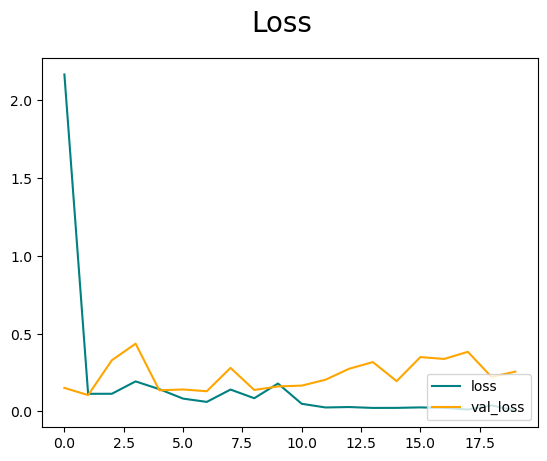

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="lower right")
plt.show()

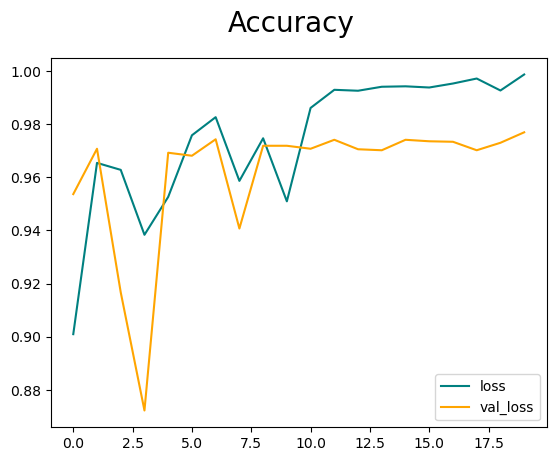

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

# Testing with a batch

In [23]:
# Defining prediction dataset
pred_dataset = tf.keras.preprocessing.image_dataset_from_directory('img_data/predict', image_size=(300,300))

Found 10 files belonging to 2 classes.


In [24]:
# Evaluating the model using the prediction dataset
model_loss, model_accuracy = model.evaluate(pred_dataset,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1/1 - 0s - loss: 0.4866 - accuracy: 0.8000 - precision_1: 0.7143 - recall_1: 1.0000 - 162ms/epoch - 162ms/step


ValueError: too many values to unpack (expected 2)

**Result**

Accuracy of 80%, with precision of 71.4% and recall of 100%.
This means that in the model failed to correctly classify one in five photos overall. 71.4% of the time it correctly predicted that an image displayed skin cancer. When the model identified an image as showing skin cancer, it was always correct.

# Testing with a single picture

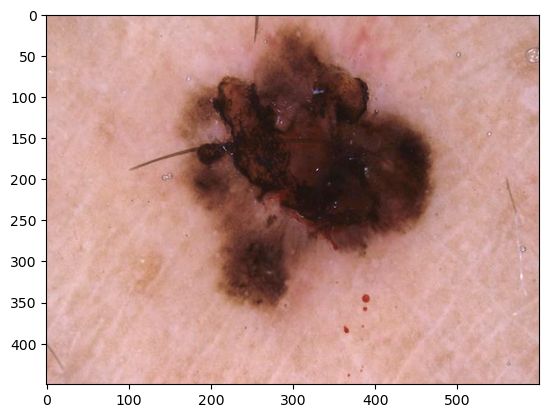

In [32]:
# Feeding model with a photo with a ground truth of having skin cancer

# Loading in image and fixing colour
img1 = cv2.imread('predict2/ISIC_0031310.jpg')
img1_corrected= cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1_corrected)

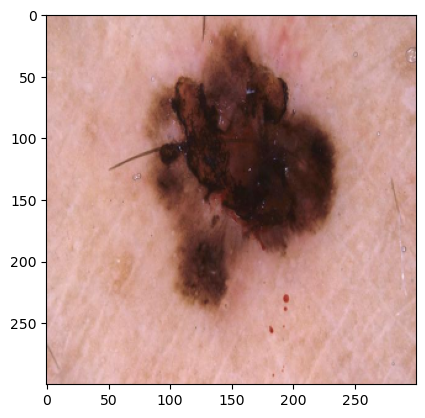

In [33]:
# Resizing to the right size for the model
resize1 = tf.image.resize(img1_corrected, (300,300))
plt.imshow(resize1.numpy().astype(int))
plt.show()

In [34]:
# Model prediction
pred1 = model.predict(np.expand_dims(resize1/255, 0))

pred1

1/1 [==============================] - 0s 115ms/step


array([[1.]], dtype=float32)

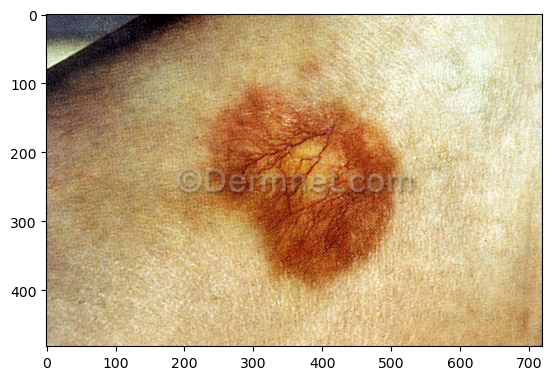

In [35]:
# Feeding model with a photo with a ground truth of NOT having skin cancer

# Loading in image and fixing colour
img2 = cv2.imread('predict2/necrobiosis-lipoidica-33.jpg')
img2_corrected= cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2_corrected)

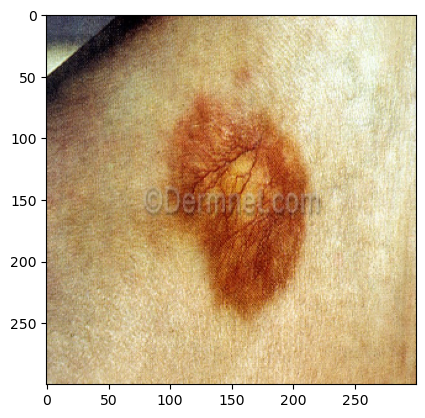

In [36]:
# Resizing to the right size for the model
resize2 = tf.image.resize(img2_corrected, (300,300))
plt.imshow(resize2.numpy().astype(int))
plt.show()

In [37]:
# Model prediction
pred2 = model.predict(np.expand_dims(resize2/255, 0))

pred2

1/1 [==============================] - 0s 25ms/step


array([[1.]], dtype=float32)

**Results**

Correctly identified skin cancer image, but failed to correctly identify non-skin cancer image.

## Saving the model

In [38]:
# Export our model to HDF5 file
model.save("prod_1.h5")

C:\Users\dalet\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Moving forward** 

- Create preprocessing script that will accompany the model
- Remove resizing layer as preprocessing script will handle that, and also input layer exists to ensure that model is given data with the right dimensions
- Create new model with new preprocessed image datasets and reduce epochs to 10
- Recreate training, validation and test files to provide more data for training and also to create a dataset made for rigorous testing
- Implement confusion matrix evaluation